# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

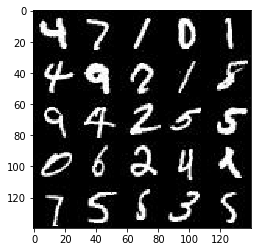

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

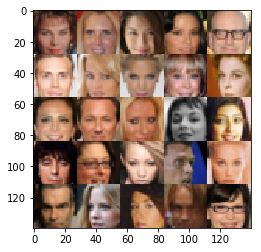

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate_input')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        # MNIST: 1 color channel
        # CelebA: 3 color channels
        # Input layer is 28x28xcc
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Leaky ReLU
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        # Dropout
        keep_prob = 0.6
        x1 =  tf.contrib.layers.dropout(x1, keep_prob=keep_prob, is_training=True)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        # Dropout
        x2 =  tf.contrib.layers.dropout(x2, keep_prob=keep_prob, is_training=True)
        
        x3 = tf.layers.conv2d(x2, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        # Dropout
        x3 =  tf.contrib.layers.dropout(x3, keep_prob=keep_prob, is_training=True)

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Sigmoid output
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        alpha=0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        # Dropout
        keep_prob = 0.5
        x1 =  tf.contrib.layers.dropout(x1, keep_prob=keep_prob, is_training=is_train)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        # Dropout
        x2 =  tf.contrib.layers.dropout(x2, keep_prob=keep_prob, is_training=is_train)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
         # Dropout
        x3 =  tf.contrib.layers.dropout(x3, keep_prob=keep_prob, is_training=is_train)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Smoothing
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    
    # Init the GAN
    # tf.reset_default_graph()
    nb_examples, width, height, image_channels = data_shape
    input_real, input_z, learning_rate_input = model_inputs(width, height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Normalize the input images
                # The values of the MNIST and CelebA dataset are in the range of -0.5 to 0.5 of 28x28 dimensional images.
                # So we need to multiply the batch images by 2 to be in the range of -1.0 to 1.0 .
                batch_images = batch_images * 2.0

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_input: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_input: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9869... Generator Loss: 1.3906
Epoch 1/2... Discriminator Loss: 2.1329... Generator Loss: 0.5803
Epoch 1/2... Discriminator Loss: 1.5850... Generator Loss: 0.8508
Epoch 1/2... Discriminator Loss: 1.6988... Generator Loss: 0.7865
Epoch 1/2... Discriminator Loss: 1.0076... Generator Loss: 1.6239
Epoch 1/2... Discriminator Loss: 1.2017... Generator Loss: 1.2049
Epoch 1/2... Discriminator Loss: 0.6152... Generator Loss: 2.3506
Epoch 1/2... Discriminator Loss: 1.7755... Generator Loss: 8.4337
Epoch 1/2... Discriminator Loss: 0.9092... Generator Loss: 3.6881
Epoch 1/2... Discriminator Loss: 1.6230... Generator Loss: 0.5997


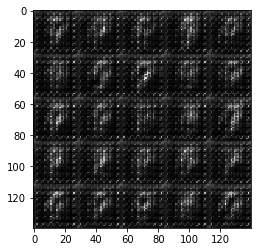

Epoch 1/2... Discriminator Loss: 1.5222... Generator Loss: 1.0073
Epoch 1/2... Discriminator Loss: 1.2694... Generator Loss: 1.1127
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 1.8679
Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 2.1539
Epoch 1/2... Discriminator Loss: 2.1432... Generator Loss: 0.5505
Epoch 1/2... Discriminator Loss: 1.4885... Generator Loss: 0.5741
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 1.0287
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 1.1500
Epoch 1/2... Discriminator Loss: 0.9905... Generator Loss: 1.9204
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 1.2536


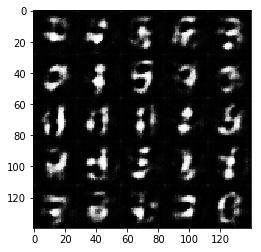

Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 1.5228
Epoch 1/2... Discriminator Loss: 1.2296... Generator Loss: 1.4739
Epoch 1/2... Discriminator Loss: 0.9847... Generator Loss: 1.2332
Epoch 1/2... Discriminator Loss: 1.1272... Generator Loss: 0.8855
Epoch 1/2... Discriminator Loss: 1.3697... Generator Loss: 1.1872
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 1.3729
Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 1.1960
Epoch 1/2... Discriminator Loss: 1.0392... Generator Loss: 1.9246
Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 2.3778
Epoch 1/2... Discriminator Loss: 1.2422... Generator Loss: 1.4680


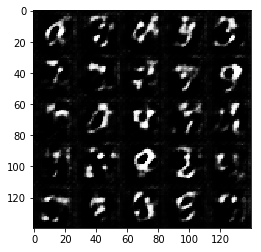

Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 1.7401
Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 0.9960
Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 1.2909
Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 1.6711
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.8917
Epoch 1/2... Discriminator Loss: 1.1789... Generator Loss: 1.2023
Epoch 1/2... Discriminator Loss: 1.4095... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 1.1660
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 1.2537


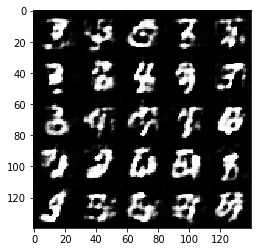

Epoch 1/2... Discriminator Loss: 1.0773... Generator Loss: 1.0400
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 0.7294
Epoch 1/2... Discriminator Loss: 1.2475... Generator Loss: 1.3266
Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 1.3827
Epoch 1/2... Discriminator Loss: 1.2566... Generator Loss: 0.8074
Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 1.8608
Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 1.7381
Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 1.1323
Epoch 1/2... Discriminator Loss: 1.1498... Generator Loss: 1.0393
Epoch 1/2... Discriminator Loss: 0.9947... Generator Loss: 1.0295


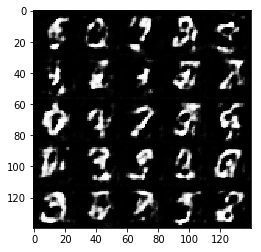

Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 1.2525
Epoch 1/2... Discriminator Loss: 1.0922... Generator Loss: 1.7943
Epoch 1/2... Discriminator Loss: 1.0412... Generator Loss: 2.0538
Epoch 1/2... Discriminator Loss: 0.9709... Generator Loss: 1.5784
Epoch 1/2... Discriminator Loss: 1.5267... Generator Loss: 0.6329
Epoch 1/2... Discriminator Loss: 0.9555... Generator Loss: 1.1906
Epoch 1/2... Discriminator Loss: 1.2032... Generator Loss: 1.1246
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.8288
Epoch 1/2... Discriminator Loss: 0.9791... Generator Loss: 1.4017
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 0.9529


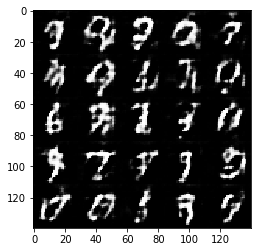

Epoch 1/2... Discriminator Loss: 1.0639... Generator Loss: 1.0983
Epoch 1/2... Discriminator Loss: 0.9555... Generator Loss: 1.1689
Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.4942
Epoch 1/2... Discriminator Loss: 1.1758... Generator Loss: 1.8815
Epoch 1/2... Discriminator Loss: 1.1830... Generator Loss: 0.8351
Epoch 1/2... Discriminator Loss: 0.9719... Generator Loss: 1.3938
Epoch 1/2... Discriminator Loss: 0.9500... Generator Loss: 0.9736
Epoch 1/2... Discriminator Loss: 1.0705... Generator Loss: 0.9833
Epoch 1/2... Discriminator Loss: 1.0412... Generator Loss: 1.4729
Epoch 1/2... Discriminator Loss: 0.9843... Generator Loss: 1.4252


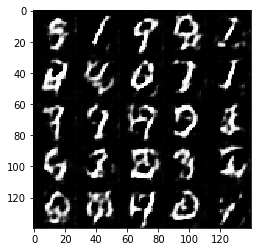

Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 1.7552
Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 1.6812
Epoch 1/2... Discriminator Loss: 1.1446... Generator Loss: 1.2483
Epoch 1/2... Discriminator Loss: 1.1001... Generator Loss: 1.0246
Epoch 1/2... Discriminator Loss: 1.1503... Generator Loss: 1.7701
Epoch 1/2... Discriminator Loss: 1.0830... Generator Loss: 1.2819
Epoch 1/2... Discriminator Loss: 1.1657... Generator Loss: 1.8878
Epoch 1/2... Discriminator Loss: 1.1636... Generator Loss: 0.8519
Epoch 1/2... Discriminator Loss: 1.4278... Generator Loss: 2.9797
Epoch 1/2... Discriminator Loss: 1.0607... Generator Loss: 1.6102


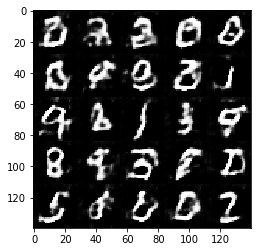

Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 2.1842
Epoch 1/2... Discriminator Loss: 1.2529... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 1.3563
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.1982... Generator Loss: 1.5724
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 1.5736
Epoch 1/2... Discriminator Loss: 1.3015... Generator Loss: 2.1212
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 1.3914
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 1.0128
Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 1.1410


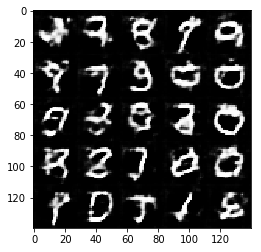

Epoch 1/2... Discriminator Loss: 1.2201... Generator Loss: 0.8886
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 0.8676
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 1.8495
Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 0.8840
Epoch 1/2... Discriminator Loss: 1.0535... Generator Loss: 1.3912
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 1.3448
Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 1.4319
Epoch 1/2... Discriminator Loss: 1.2476... Generator Loss: 0.8346
Epoch 1/2... Discriminator Loss: 1.1671... Generator Loss: 0.9570
Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 1.7239


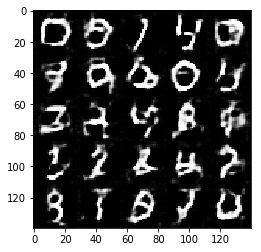

Epoch 1/2... Discriminator Loss: 1.0513... Generator Loss: 0.9841
Epoch 1/2... Discriminator Loss: 1.0216... Generator Loss: 1.3681
Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 1.5087
Epoch 1/2... Discriminator Loss: 0.8372... Generator Loss: 1.0012
Epoch 1/2... Discriminator Loss: 1.1824... Generator Loss: 1.8003
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 2.1734
Epoch 1/2... Discriminator Loss: 0.9398... Generator Loss: 1.3907
Epoch 1/2... Discriminator Loss: 1.2332... Generator Loss: 0.7220
Epoch 1/2... Discriminator Loss: 1.0775... Generator Loss: 1.4953
Epoch 1/2... Discriminator Loss: 0.9859... Generator Loss: 1.4442


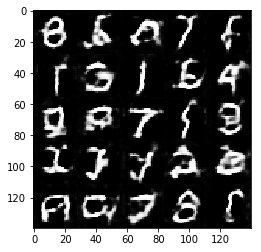

Epoch 1/2... Discriminator Loss: 1.0425... Generator Loss: 1.1601
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 1.1611
Epoch 1/2... Discriminator Loss: 1.2262... Generator Loss: 2.5848
Epoch 1/2... Discriminator Loss: 0.8698... Generator Loss: 0.8504
Epoch 1/2... Discriminator Loss: 0.8863... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.0174... Generator Loss: 1.3875
Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 2.2138
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 1.2792
Epoch 1/2... Discriminator Loss: 1.3719... Generator Loss: 0.9043
Epoch 1/2... Discriminator Loss: 0.9504... Generator Loss: 2.1142


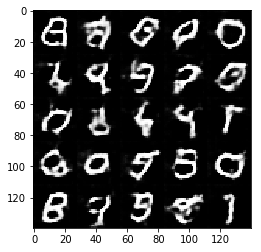

Epoch 1/2... Discriminator Loss: 1.0775... Generator Loss: 1.3499
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 1.2874
Epoch 1/2... Discriminator Loss: 0.9481... Generator Loss: 0.9017
Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 1.0525
Epoch 1/2... Discriminator Loss: 1.0728... Generator Loss: 1.2988
Epoch 1/2... Discriminator Loss: 1.1475... Generator Loss: 1.0782
Epoch 1/2... Discriminator Loss: 1.5127... Generator Loss: 2.8395
Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 1.5573
Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 0.6095
Epoch 1/2... Discriminator Loss: 1.2934... Generator Loss: 0.7984


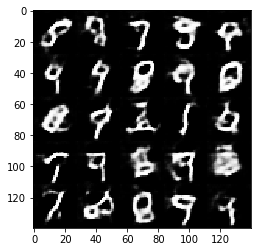

Epoch 1/2... Discriminator Loss: 0.9684... Generator Loss: 0.9571
Epoch 1/2... Discriminator Loss: 0.9917... Generator Loss: 1.6574
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 0.9966
Epoch 1/2... Discriminator Loss: 1.2426... Generator Loss: 1.0202
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 1.2704
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 1.1335
Epoch 1/2... Discriminator Loss: 1.0187... Generator Loss: 1.4455
Epoch 1/2... Discriminator Loss: 1.0823... Generator Loss: 1.4557
Epoch 1/2... Discriminator Loss: 0.8961... Generator Loss: 1.8724
Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 1.5619


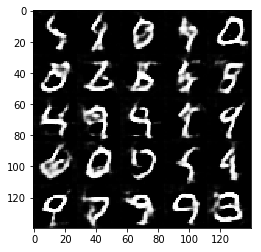

Epoch 1/2... Discriminator Loss: 1.0525... Generator Loss: 1.2586
Epoch 1/2... Discriminator Loss: 0.8820... Generator Loss: 1.4271
Epoch 1/2... Discriminator Loss: 1.0308... Generator Loss: 1.2392
Epoch 1/2... Discriminator Loss: 1.0105... Generator Loss: 1.4984
Epoch 1/2... Discriminator Loss: 0.9850... Generator Loss: 1.1066
Epoch 1/2... Discriminator Loss: 0.9917... Generator Loss: 1.8333
Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 1.3843
Epoch 1/2... Discriminator Loss: 1.2317... Generator Loss: 0.8023
Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 0.5460
Epoch 1/2... Discriminator Loss: 0.9432... Generator Loss: 2.1271


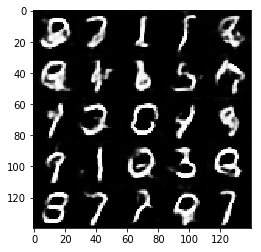

Epoch 1/2... Discriminator Loss: 1.2402... Generator Loss: 1.2521
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 1.2710
Epoch 1/2... Discriminator Loss: 0.9642... Generator Loss: 2.3146
Epoch 1/2... Discriminator Loss: 1.1878... Generator Loss: 1.7871
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 1.3154
Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 0.7202
Epoch 1/2... Discriminator Loss: 0.9754... Generator Loss: 1.1169
Epoch 1/2... Discriminator Loss: 1.1698... Generator Loss: 0.9346
Epoch 1/2... Discriminator Loss: 1.1592... Generator Loss: 1.4752


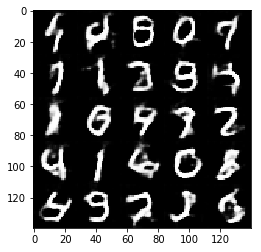

Epoch 1/2... Discriminator Loss: 1.0230... Generator Loss: 2.2839
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 1.5865
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 1.2653
Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 1.8494
Epoch 1/2... Discriminator Loss: 1.2962... Generator Loss: 1.7325
Epoch 1/2... Discriminator Loss: 1.0120... Generator Loss: 0.7963
Epoch 1/2... Discriminator Loss: 1.5902... Generator Loss: 0.7661
Epoch 1/2... Discriminator Loss: 1.3012... Generator Loss: 0.8564
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 1.6932
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 1.2083


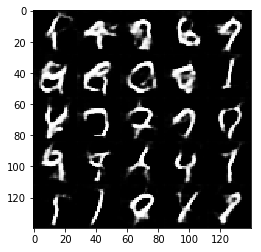

Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 1.1293
Epoch 1/2... Discriminator Loss: 1.4395... Generator Loss: 1.6386
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 1.4692
Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 1.4740
Epoch 1/2... Discriminator Loss: 1.1543... Generator Loss: 0.9525
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 1.2077
Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 1.2493
Epoch 1/2... Discriminator Loss: 1.6904... Generator Loss: 2.4364
Epoch 1/2... Discriminator Loss: 0.9524... Generator Loss: 1.6506
Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 2.0100


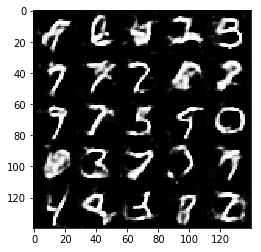

Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 1.2232
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 2.6118
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 0.9798
Epoch 1/2... Discriminator Loss: 1.1347... Generator Loss: 1.2702
Epoch 1/2... Discriminator Loss: 0.8978... Generator Loss: 1.4776
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 0.8268
Epoch 1/2... Discriminator Loss: 0.9544... Generator Loss: 1.0286
Epoch 2/2... Discriminator Loss: 0.9835... Generator Loss: 2.3213
Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 2.7311
Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 1.3254


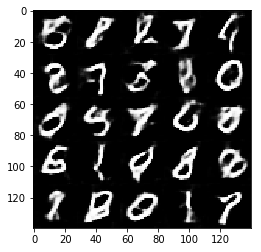

Epoch 2/2... Discriminator Loss: 1.0094... Generator Loss: 1.2872
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 1.0149... Generator Loss: 1.8792
Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 1.4221
Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 1.0434
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 1.0176
Epoch 2/2... Discriminator Loss: 1.1270... Generator Loss: 2.2470
Epoch 2/2... Discriminator Loss: 0.8898... Generator Loss: 1.5656
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 1.0487
Epoch 2/2... Discriminator Loss: 1.0615... Generator Loss: 0.9084


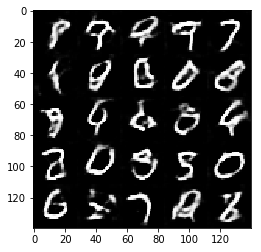

Epoch 2/2... Discriminator Loss: 0.9087... Generator Loss: 1.0126
Epoch 2/2... Discriminator Loss: 1.1468... Generator Loss: 1.3062
Epoch 2/2... Discriminator Loss: 1.2388... Generator Loss: 0.8699
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 1.2104
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 1.9601
Epoch 2/2... Discriminator Loss: 0.7436... Generator Loss: 1.3102
Epoch 2/2... Discriminator Loss: 0.9011... Generator Loss: 1.5451
Epoch 2/2... Discriminator Loss: 1.1755... Generator Loss: 0.9279
Epoch 2/2... Discriminator Loss: 1.0815... Generator Loss: 1.3959
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 1.4621


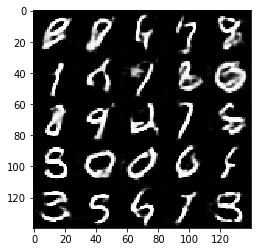

Epoch 2/2... Discriminator Loss: 1.0677... Generator Loss: 1.1118
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 2.4444
Epoch 2/2... Discriminator Loss: 1.1071... Generator Loss: 1.4471
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 1.4885
Epoch 2/2... Discriminator Loss: 0.9363... Generator Loss: 1.7722
Epoch 2/2... Discriminator Loss: 0.9148... Generator Loss: 1.5453
Epoch 2/2... Discriminator Loss: 1.2841... Generator Loss: 1.2899
Epoch 2/2... Discriminator Loss: 1.0484... Generator Loss: 1.0634
Epoch 2/2... Discriminator Loss: 0.8181... Generator Loss: 0.7688
Epoch 2/2... Discriminator Loss: 0.9595... Generator Loss: 1.8058


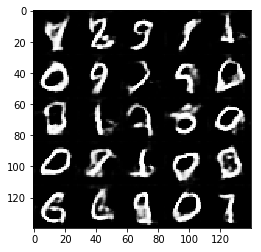

Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 1.3625
Epoch 2/2... Discriminator Loss: 1.0256... Generator Loss: 1.1570
Epoch 2/2... Discriminator Loss: 0.9117... Generator Loss: 1.1774
Epoch 2/2... Discriminator Loss: 0.8359... Generator Loss: 1.4096
Epoch 2/2... Discriminator Loss: 0.9292... Generator Loss: 1.8303
Epoch 2/2... Discriminator Loss: 1.0784... Generator Loss: 0.7218
Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 1.2753
Epoch 2/2... Discriminator Loss: 0.9777... Generator Loss: 2.2948
Epoch 2/2... Discriminator Loss: 1.0067... Generator Loss: 1.7567
Epoch 2/2... Discriminator Loss: 0.9875... Generator Loss: 1.0705


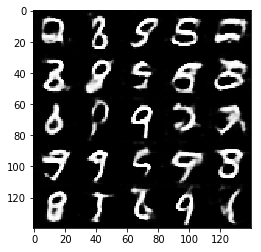

Epoch 2/2... Discriminator Loss: 0.8280... Generator Loss: 1.6136
Epoch 2/2... Discriminator Loss: 0.8061... Generator Loss: 1.4687
Epoch 2/2... Discriminator Loss: 0.9876... Generator Loss: 1.6379
Epoch 2/2... Discriminator Loss: 1.0277... Generator Loss: 1.2517
Epoch 2/2... Discriminator Loss: 0.7887... Generator Loss: 1.9312
Epoch 2/2... Discriminator Loss: 0.8788... Generator Loss: 2.4124
Epoch 2/2... Discriminator Loss: 0.8683... Generator Loss: 1.4328
Epoch 2/2... Discriminator Loss: 1.1360... Generator Loss: 0.7782
Epoch 2/2... Discriminator Loss: 1.6722... Generator Loss: 0.5537
Epoch 2/2... Discriminator Loss: 1.1106... Generator Loss: 3.3589


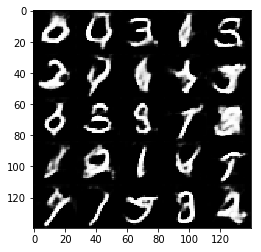

Epoch 2/2... Discriminator Loss: 0.8292... Generator Loss: 1.1913
Epoch 2/2... Discriminator Loss: 0.9965... Generator Loss: 1.8655
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.2464
Epoch 2/2... Discriminator Loss: 0.6954... Generator Loss: 2.1311
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 2.1189
Epoch 2/2... Discriminator Loss: 0.9758... Generator Loss: 1.1729
Epoch 2/2... Discriminator Loss: 1.0141... Generator Loss: 1.3488
Epoch 2/2... Discriminator Loss: 0.9459... Generator Loss: 1.1365
Epoch 2/2... Discriminator Loss: 0.9580... Generator Loss: 0.8679
Epoch 2/2... Discriminator Loss: 0.8471... Generator Loss: 1.3662


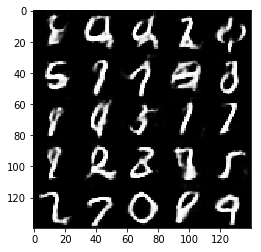

Epoch 2/2... Discriminator Loss: 0.9398... Generator Loss: 1.7474
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 2.9070
Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.4678
Epoch 2/2... Discriminator Loss: 0.9489... Generator Loss: 1.0374
Epoch 2/2... Discriminator Loss: 0.7234... Generator Loss: 1.7666
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 2.1289
Epoch 2/2... Discriminator Loss: 0.6869... Generator Loss: 1.8424
Epoch 2/2... Discriminator Loss: 0.7120... Generator Loss: 2.0842
Epoch 2/2... Discriminator Loss: 0.9211... Generator Loss: 1.6471
Epoch 2/2... Discriminator Loss: 1.6007... Generator Loss: 3.3447


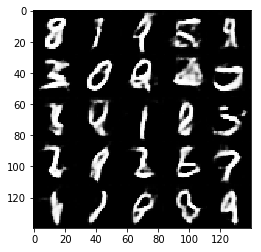

Epoch 2/2... Discriminator Loss: 0.7347... Generator Loss: 1.5579
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 1.4668
Epoch 2/2... Discriminator Loss: 1.0660... Generator Loss: 2.1140
Epoch 2/2... Discriminator Loss: 0.7868... Generator Loss: 1.2039
Epoch 2/2... Discriminator Loss: 0.7533... Generator Loss: 2.1834
Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 2.6224
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 1.5073
Epoch 2/2... Discriminator Loss: 0.7868... Generator Loss: 2.3129
Epoch 2/2... Discriminator Loss: 0.8210... Generator Loss: 1.6754
Epoch 2/2... Discriminator Loss: 0.7790... Generator Loss: 2.0280


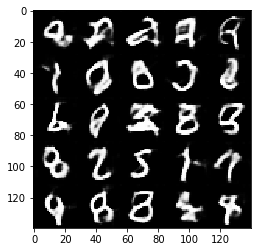

Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 1.9249
Epoch 2/2... Discriminator Loss: 1.0420... Generator Loss: 2.2989
Epoch 2/2... Discriminator Loss: 0.9893... Generator Loss: 1.3382
Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 0.7818
Epoch 2/2... Discriminator Loss: 0.7338... Generator Loss: 1.4810
Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.6639
Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 1.3243
Epoch 2/2... Discriminator Loss: 0.8931... Generator Loss: 1.1895
Epoch 2/2... Discriminator Loss: 0.8212... Generator Loss: 1.9095
Epoch 2/2... Discriminator Loss: 1.7284... Generator Loss: 0.5560


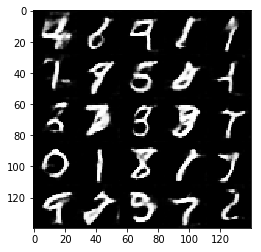

Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 0.9701
Epoch 2/2... Discriminator Loss: 0.6021... Generator Loss: 2.1574
Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.5259
Epoch 2/2... Discriminator Loss: 0.9954... Generator Loss: 0.8979
Epoch 2/2... Discriminator Loss: 0.7902... Generator Loss: 1.6448
Epoch 2/2... Discriminator Loss: 0.9055... Generator Loss: 1.7457
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 1.9730
Epoch 2/2... Discriminator Loss: 0.8313... Generator Loss: 2.3809
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 2.9058
Epoch 2/2... Discriminator Loss: 0.6520... Generator Loss: 2.0664


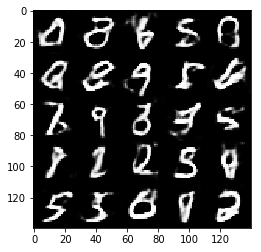

Epoch 2/2... Discriminator Loss: 0.7863... Generator Loss: 1.5743
Epoch 2/2... Discriminator Loss: 0.7732... Generator Loss: 1.1203
Epoch 2/2... Discriminator Loss: 1.0886... Generator Loss: 0.7461
Epoch 2/2... Discriminator Loss: 1.0827... Generator Loss: 0.9237
Epoch 2/2... Discriminator Loss: 1.0913... Generator Loss: 1.1850
Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 2.5846
Epoch 2/2... Discriminator Loss: 0.8874... Generator Loss: 1.4600
Epoch 2/2... Discriminator Loss: 0.8437... Generator Loss: 0.9579
Epoch 2/2... Discriminator Loss: 1.2328... Generator Loss: 3.6107
Epoch 2/2... Discriminator Loss: 1.1486... Generator Loss: 1.0342


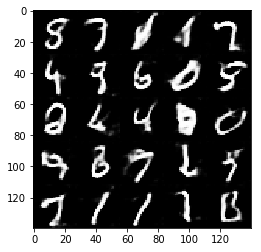

Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 1.8789
Epoch 2/2... Discriminator Loss: 0.7375... Generator Loss: 1.8275
Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 1.3693
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 2.0644
Epoch 2/2... Discriminator Loss: 1.6751... Generator Loss: 0.7545
Epoch 2/2... Discriminator Loss: 0.9215... Generator Loss: 1.4599
Epoch 2/2... Discriminator Loss: 0.8243... Generator Loss: 2.4979
Epoch 2/2... Discriminator Loss: 0.8398... Generator Loss: 1.6924
Epoch 2/2... Discriminator Loss: 1.0658... Generator Loss: 3.0210
Epoch 2/2... Discriminator Loss: 0.8016... Generator Loss: 1.5621


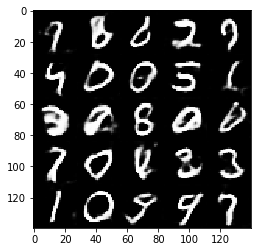

Epoch 2/2... Discriminator Loss: 0.8795... Generator Loss: 2.1136
Epoch 2/2... Discriminator Loss: 1.7868... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 0.6654... Generator Loss: 1.3887
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 1.4877
Epoch 2/2... Discriminator Loss: 0.8499... Generator Loss: 2.1903
Epoch 2/2... Discriminator Loss: 0.7104... Generator Loss: 1.6520
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 1.0874
Epoch 2/2... Discriminator Loss: 1.0523... Generator Loss: 1.0516
Epoch 2/2... Discriminator Loss: 1.4441... Generator Loss: 0.5192
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 1.8952


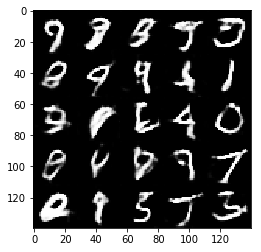

Epoch 2/2... Discriminator Loss: 0.6633... Generator Loss: 2.1619
Epoch 2/2... Discriminator Loss: 0.7441... Generator Loss: 1.9787
Epoch 2/2... Discriminator Loss: 1.7238... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 0.6604... Generator Loss: 1.9560
Epoch 2/2... Discriminator Loss: 0.6883... Generator Loss: 1.4159
Epoch 2/2... Discriminator Loss: 0.8287... Generator Loss: 2.2595
Epoch 2/2... Discriminator Loss: 0.9313... Generator Loss: 1.4491
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 2.2831
Epoch 2/2... Discriminator Loss: 1.0377... Generator Loss: 3.0938
Epoch 2/2... Discriminator Loss: 0.8249... Generator Loss: 2.5745


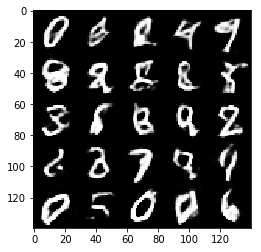

Epoch 2/2... Discriminator Loss: 0.6463... Generator Loss: 1.4963
Epoch 2/2... Discriminator Loss: 0.6822... Generator Loss: 1.5409
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 2.1269
Epoch 2/2... Discriminator Loss: 0.8459... Generator Loss: 1.6220
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 2.7309
Epoch 2/2... Discriminator Loss: 0.7770... Generator Loss: 2.9450
Epoch 2/2... Discriminator Loss: 0.7325... Generator Loss: 2.8717
Epoch 2/2... Discriminator Loss: 0.8687... Generator Loss: 3.2856
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 2.7069
Epoch 2/2... Discriminator Loss: 0.8646... Generator Loss: 1.5230


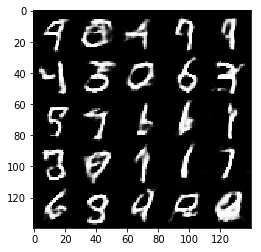

Epoch 2/2... Discriminator Loss: 1.3065... Generator Loss: 3.7393
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 1.7905
Epoch 2/2... Discriminator Loss: 0.9256... Generator Loss: 2.1491
Epoch 2/2... Discriminator Loss: 0.7259... Generator Loss: 1.6729
Epoch 2/2... Discriminator Loss: 0.7941... Generator Loss: 2.1051
Epoch 2/2... Discriminator Loss: 0.7623... Generator Loss: 1.6936
Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 0.8935
Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 1.6155
Epoch 2/2... Discriminator Loss: 0.7115... Generator Loss: 1.1608
Epoch 2/2... Discriminator Loss: 0.6060... Generator Loss: 2.9248


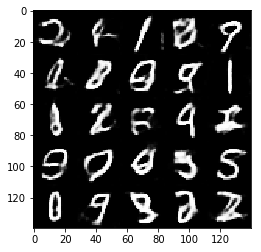

Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 0.6179
Epoch 2/2... Discriminator Loss: 0.7039... Generator Loss: 2.2026
Epoch 2/2... Discriminator Loss: 0.9564... Generator Loss: 1.2685
Epoch 2/2... Discriminator Loss: 0.7155... Generator Loss: 2.1976
Epoch 2/2... Discriminator Loss: 0.7248... Generator Loss: 1.3124
Epoch 2/2... Discriminator Loss: 0.7401... Generator Loss: 1.7049
Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 1.4027
Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 2.5142
Epoch 2/2... Discriminator Loss: 0.6341... Generator Loss: 2.2244
Epoch 2/2... Discriminator Loss: 0.9383... Generator Loss: 1.8167


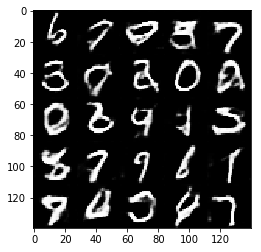

Epoch 2/2... Discriminator Loss: 0.6718... Generator Loss: 1.9087
Epoch 2/2... Discriminator Loss: 0.8146... Generator Loss: 2.4421
Epoch 2/2... Discriminator Loss: 0.7614... Generator Loss: 1.6148
Epoch 2/2... Discriminator Loss: 0.6161... Generator Loss: 1.9422
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 1.7970
Epoch 2/2... Discriminator Loss: 0.8331... Generator Loss: 2.2132
Epoch 2/2... Discriminator Loss: 0.5378... Generator Loss: 2.2888
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 0.8949
Epoch 2/2... Discriminator Loss: 0.6602... Generator Loss: 1.8393
Epoch 2/2... Discriminator Loss: 1.3419... Generator Loss: 2.6278


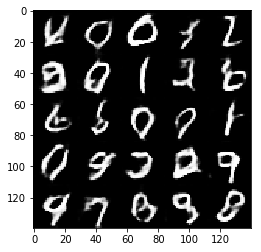

Epoch 2/2... Discriminator Loss: 0.5169... Generator Loss: 2.7029
Epoch 2/2... Discriminator Loss: 0.6191... Generator Loss: 0.8084
Epoch 2/2... Discriminator Loss: 1.0270... Generator Loss: 2.3034
Epoch 2/2... Discriminator Loss: 0.6499... Generator Loss: 2.5989
Epoch 2/2... Discriminator Loss: 0.7461... Generator Loss: 2.4201


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7016... Generator Loss: 2.1856
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 3.5401
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 3.5711
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 4.3931
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 6.2160
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 2.0204
Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 5.2094
Epoch 1/1... Discriminator Loss: 0.7762... Generator Loss: 2.5013
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 2.1325
Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 2.0745


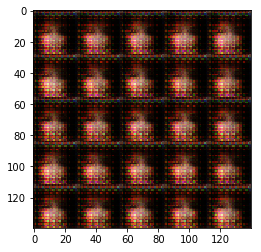

Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 1.4532
Epoch 1/1... Discriminator Loss: 0.5150... Generator Loss: 3.7262
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 7.9852
Epoch 1/1... Discriminator Loss: 0.5188... Generator Loss: 4.1817
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 3.2698
Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 8.4325
Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 2.2583
Epoch 1/1... Discriminator Loss: 0.8247... Generator Loss: 1.5188
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 2.8235
Epoch 1/1... Discriminator Loss: 0.8869... Generator Loss: 1.8005


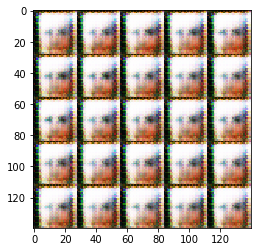

Epoch 1/1... Discriminator Loss: 0.5487... Generator Loss: 3.4043
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 2.7443
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 3.5170
Epoch 1/1... Discriminator Loss: 0.4502... Generator Loss: 7.1687
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 5.8495
Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 1.8505
Epoch 1/1... Discriminator Loss: 0.4561... Generator Loss: 3.8812
Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 4.3943
Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 5.5831
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 2.0729


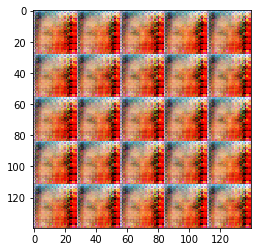

Epoch 1/1... Discriminator Loss: 0.5519... Generator Loss: 3.9905
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 5.4783
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 4.9358
Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 3.5966
Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 3.4004
Epoch 1/1... Discriminator Loss: 0.4511... Generator Loss: 3.2554
Epoch 1/1... Discriminator Loss: 0.8221... Generator Loss: 5.6846
Epoch 1/1... Discriminator Loss: 0.6068... Generator Loss: 2.8007
Epoch 1/1... Discriminator Loss: 0.7260... Generator Loss: 1.5419


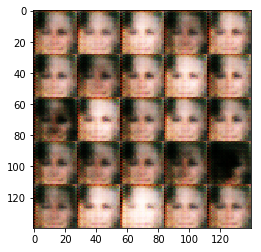

Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 1.4549
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 1.2981
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.8086
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.7110
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.8888
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 2.3434
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 1.4169
Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.3071
Epoch 1/1... Discriminator Loss: 1.6932... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 1.8793


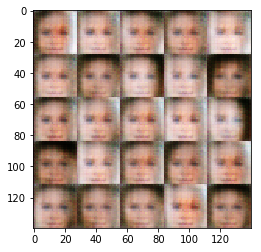

Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.8280
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.8025
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 1.2756
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.6769... Generator Loss: 2.9525
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 1.4569
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.6424
Epoch 1/1... Discriminator Loss: 1.9787... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.5837
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.8897


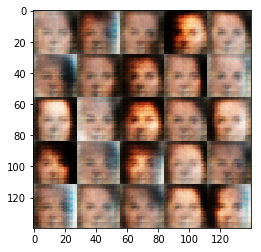

Epoch 1/1... Discriminator Loss: 1.6258... Generator Loss: 2.9392
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 1.9901
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 2.3493
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.9333... Generator Loss: 2.9177
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 1.6581
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.5314
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 1.6880
Epoch 1/1... Discriminator Loss: 1.0205... Generator Loss: 1.6546
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 2.0595


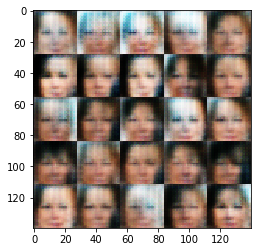

Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 2.1733
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 2.4912
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 0.8913... Generator Loss: 2.1061
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.2295
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.9467
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 2.7849
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.3245
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.2253


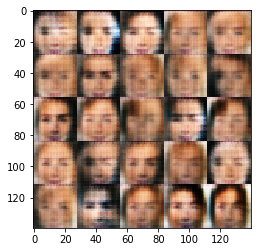

Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 1.7480
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 2.5100
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 2.4121
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 1.7047
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.2515
Epoch 1/1... Discriminator Loss: 1.2425... Generator Loss: 1.3397
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.5972
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.4623


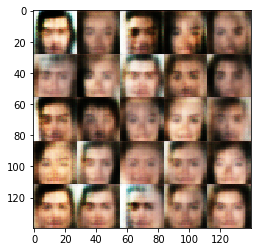

Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.8064
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.8553
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 2.0590
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 1.7866
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 2.5342
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 2.0392
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 1.5308
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 1.6684
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 2.3862
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 1.0996


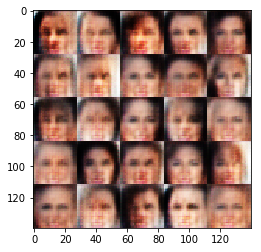

Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 2.0200
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.5318
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.5338
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 1.5623
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 2.1211
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.6217
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.2846
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.9719


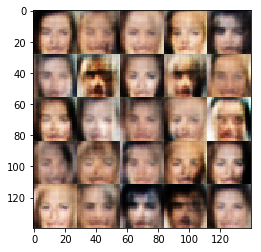

Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 1.3099
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 1.5206
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 1.7488
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.7525
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 2.0632
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 1.4583
Epoch 1/1... Discriminator Loss: 1.0036... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.6593
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.5463


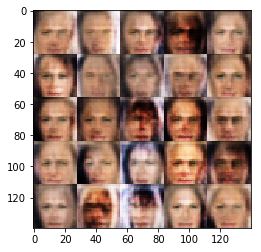

Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 1.2893
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 1.1732
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.6586
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 2.1286
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 1.3246
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 1.2348


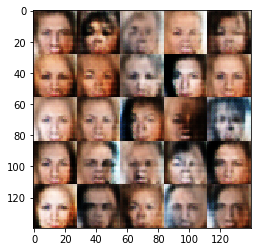

Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 1.2604
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.3092
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.5985
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 1.3131
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.3749
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 1.4313
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 1.5102
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 1.4633


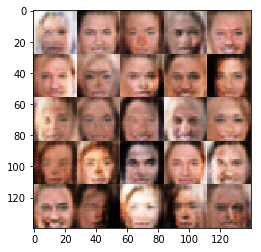

Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 2.0789
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.4758
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 1.2158
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.5588
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.0747... Generator Loss: 1.2334


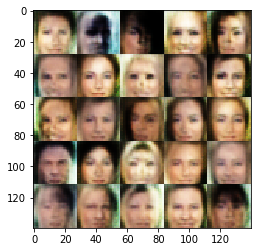

Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.4051
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 1.3238
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 1.4493
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.3596
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 1.0592
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.0002


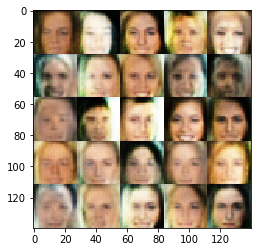

Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.8163
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 1.8414
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.9078
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 1.6261
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 1.2535
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 1.1892
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 1.0958


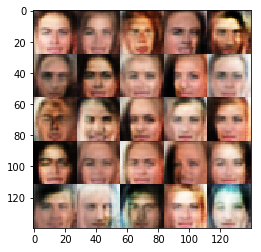

Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 1.5275
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 2.5736
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.0956
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.1732
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 1.5335
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 1.7879
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 1.1182


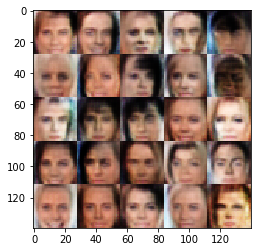

Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.3125
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 1.0552
Epoch 1/1... Discriminator Loss: 1.0814... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 1.5192
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.3669
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 1.0067


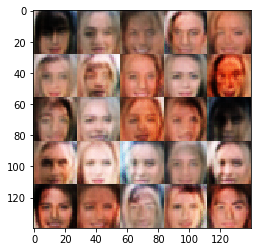

Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 1.3642
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 1.4990
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.2746
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 1.4700
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 1.5557
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.0103


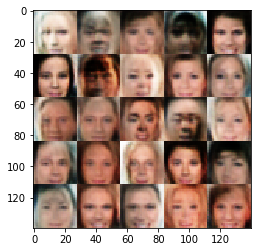

Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 2.4156
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 1.9254
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 1.6521
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 1.4711
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.1266


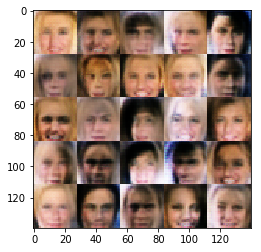

Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.1434
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 2.4756
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.9677
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.4244


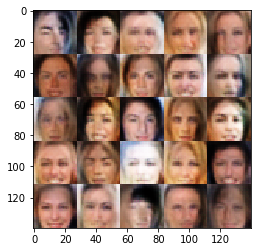

Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 1.3752
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 1.7307
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.7496
Epoch 1/1... Discriminator Loss: 0.9362... Generator Loss: 1.2198
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 1.0921
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.2878
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.2038


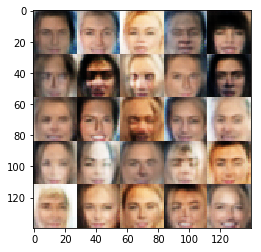

Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.7049
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 1.2696
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 1.6258
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.3953
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6523
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.6932


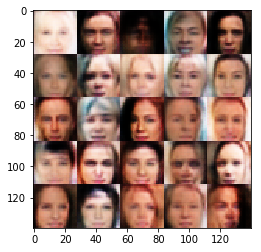

Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 0.9358... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.7343
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 1.9718
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.4320
Epoch 1/1... Discriminator Loss: 0.9746... Generator Loss: 1.5491
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.4933
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.5370
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6310


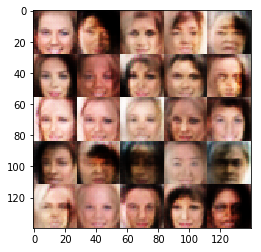

Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 1.3140
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 1.3419
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 1.2011
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 1.1870
Epoch 1/1... Discriminator Loss: 0.9773... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.3140


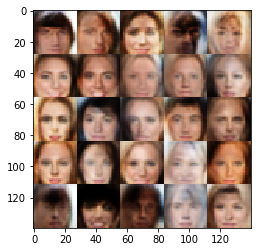

Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.8199
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 2.1923
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.3755
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 1.6385
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.4290
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.6681


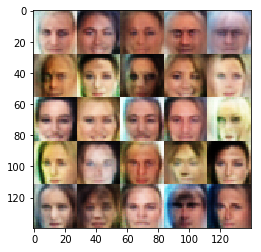

Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.6909
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.3516
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 1.2252
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.7261
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 1.0125


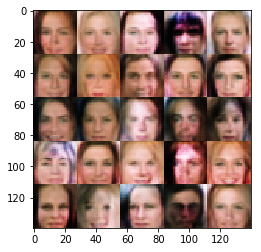

Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 1.9924
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 1.8386
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.0278
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 1.6365
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.4039
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 1.5691
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.9279


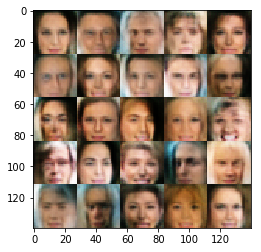

Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.5035
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.3598
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 1.0224
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 1.6922
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 1.5321
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.1598
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.3498
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 1.8467


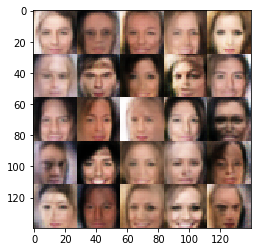

Epoch 1/1... Discriminator Loss: 0.9411... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.2138
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.3052
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 1.3874
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.0466
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.6492


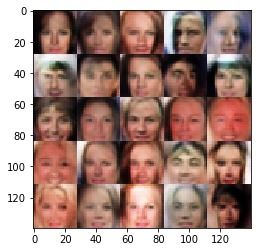

Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 1.3521
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.3791
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 1.2904
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 1.3902
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 1.5469
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.0979... Generator Loss: 1.7966
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.3833


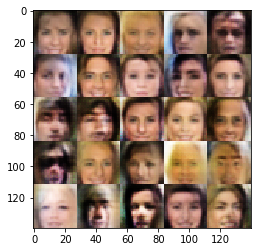

Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.7412
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 1.1208
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.4413


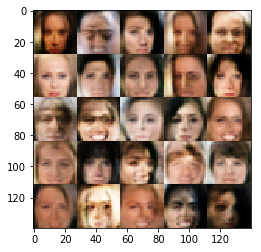

Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 1.3012
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.7147
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 1.8687
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 1.9925
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 0.9458... Generator Loss: 1.5537


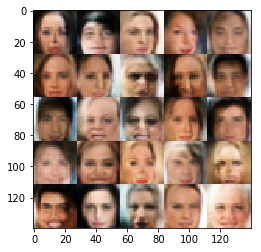

Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.6177
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.4812
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 1.5780
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 1.2375
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 1.3402
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 1.5785
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 1.3445
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.7828


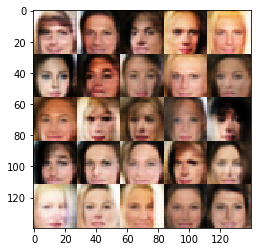

Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.8070
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.6748
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 1.2845
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 1.4265
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.3232
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.8448


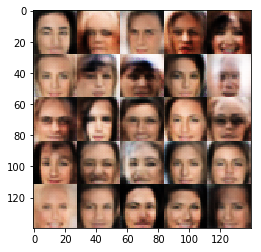

Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.5173
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.3909
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 2.1331
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.2806
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 0.9657... Generator Loss: 1.3210
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.2746
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.9376


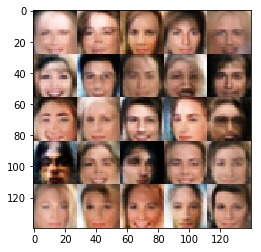

Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.3328
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 1.8003
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 1.4187
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 1.4693


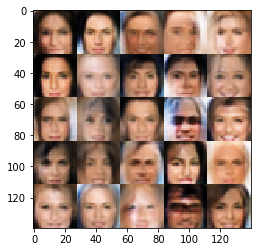

Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.4642
Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.2685
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.5562
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.4173
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 1.3895


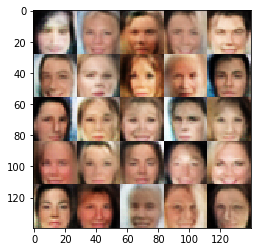

Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 1.3016
Epoch 1/1... Discriminator Loss: 1.0201... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.4976
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.6601
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 1.3611
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 0.8703... Generator Loss: 1.5136
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 1.0300
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.1946
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 1.3218


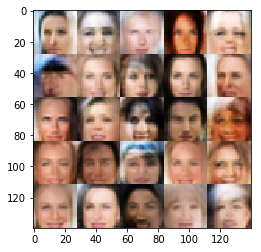

Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.4758
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 1.7159
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 1.5284
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 2.0496


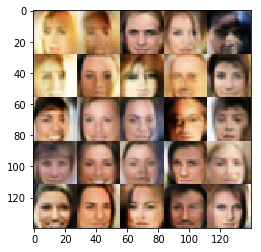

Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.4870
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.2896
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.3816
Epoch 1/1... Discriminator Loss: 0.9795... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 1.5814
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.7381


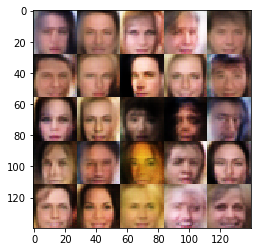

Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 1.3734
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.5915
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 1.5770
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 1.2069
Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.6092
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.0703
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.1862


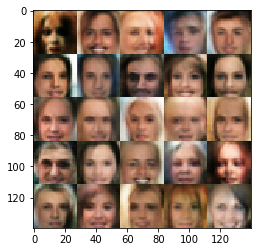

Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 1.1338
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.6689
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 1.2137
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 1.3416
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 1.0441
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 1.5380
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.8766


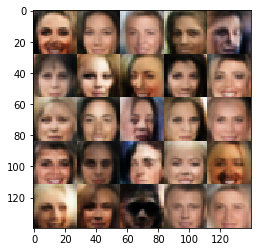

Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 1.7678
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.4324
Epoch 1/1... Discriminator Loss: 1.0488... Generator Loss: 1.1994
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.2461
Epoch 1/1... Discriminator Loss: 1.0359... Generator Loss: 1.5309
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 1.4671
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.0884
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.4760


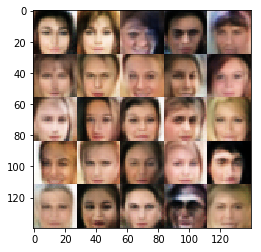

Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 1.4214
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 1.6488
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 1.7320
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.8323
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.1190


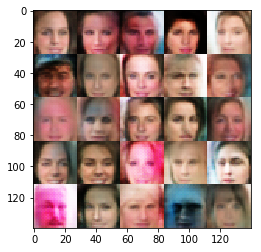

Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8018
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.4113
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.6896
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.9386
Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 1.2769
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 1.8519
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.0323
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.3597
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 1.0274


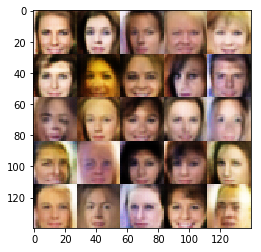

Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.5923
Epoch 1/1... Discriminator Loss: 0.8042... Generator Loss: 1.4625
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 1.5215
Epoch 1/1... Discriminator Loss: 0.9400... Generator Loss: 1.4561
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.6334
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.0088


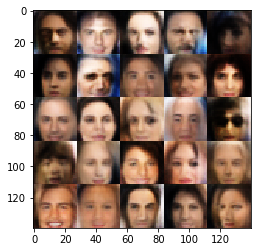

Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.8147
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.7812
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 1.9128
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 1.6915
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 1.2680
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 1.6448
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 1.5635


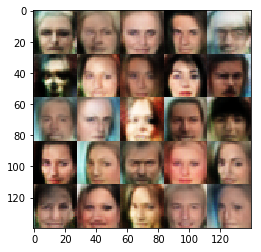

Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.2758
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 1.6316
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 1.2536
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.7559
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 1.2954
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.3994
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 1.3981
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.0397... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.6655


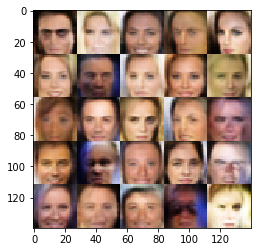

Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.1893
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 1.5863
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 1.4423
Epoch 1/1... Discriminator Loss: 1.1168... Generator Loss: 1.2351
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 1.8281
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.7155
Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 1.4182
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 1.3209
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.3097


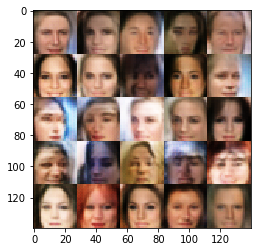

Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 1.9714
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.2136
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 1.6789
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 1.4737
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 1.6714
Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.3642


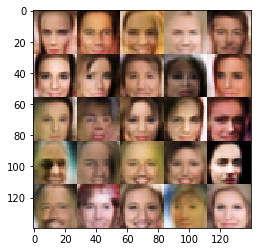

Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.2548
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 1.5875
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.5498
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 1.5203
Epoch 1/1... Discriminator Loss: 0.8205... Generator Loss: 1.4206
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.1550
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 2.4984


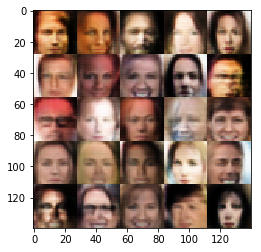

Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.2456
Epoch 1/1... Discriminator Loss: 0.8216... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 1.4812
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 1.4400
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 2.0175
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 1.2117
Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 1.6717


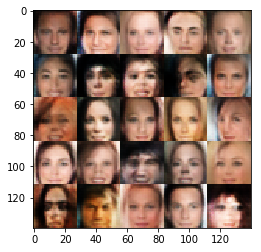

Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 1.9248
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.3386
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 2.5887
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.3298
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 1.3908
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 1.3321
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.3630


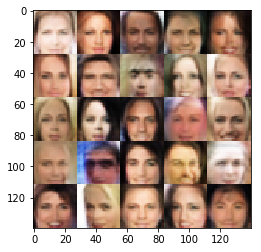

Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.3796
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 1.9601
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.7004
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.3237
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.7260
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.2822
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 1.1350
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.6420
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.9767


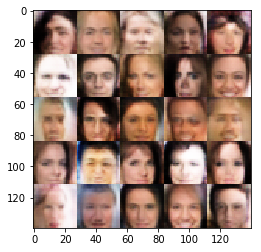

Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 2.1394
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 1.3183
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.3854
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.4890
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 0.8777... Generator Loss: 1.5260
Epoch 1/1... Discriminator Loss: 0.9158... Generator Loss: 1.3552


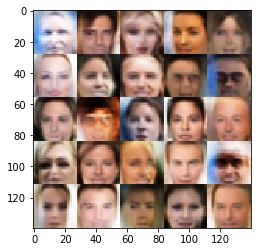

Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 1.2820
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 2.2355
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.0615
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 2.0401
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.6466
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 1.8524


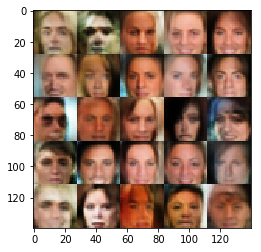

Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 1.4175
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 1.5058
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 1.4582
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.8639
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 1.2169
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 1.3333
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 2.2046
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.3733
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 1.4736


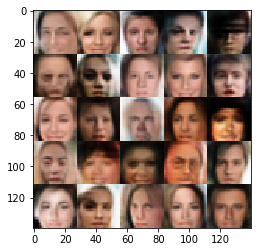

Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 1.1511
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 1.2177
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.9762
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 1.2252
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.2541
Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.0331... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 1.8032
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 1.4481
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.6850


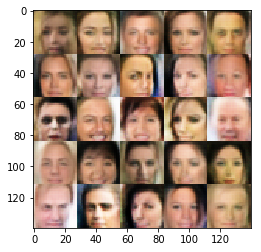

Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 1.6342
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 1.8505
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.7757
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.2028
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 2.2438
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 1.3273
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 1.3667
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.7954


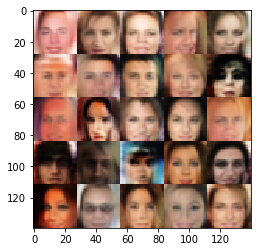

Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 2.0629
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.9165
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.6000
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 1.3431
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 1.4567
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.6118
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.4045
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 1.6829


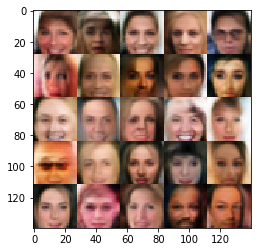

Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.5851
Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 1.6902
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.9864
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 1.6528
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 2.0147
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.5544
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.8026
Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 2.2149


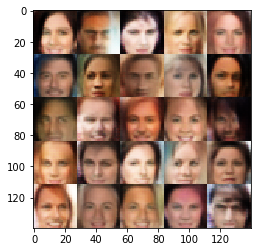

Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 1.6438
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 2.0520
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 2.0733


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.